In [1]:
import pathlib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

from pycytominer.cyto_utils import infer_cp_features

from utils.data_utils import load_data
from utils.ml_utils import (
    shuffle_columns,
    model_apply,
    cross_validation_performance,
    output_coefficients,
)

In [2]:
np.random.seed(12345)

## Set parameters for grid search

In [3]:
cs = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.4, 10]
l1_ratios = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 1]

n_folds = 5

## Load data

In [4]:
data_dict = load_data(
    return_meta=True,
    shuffle_row_order=True,
    holdout=True,
    othertreatment=True
)

print(data_dict["train"]["x"].shape)
print(data_dict["test"]["x"].shape)
print(data_dict["holdout"]["x"].shape)
print(data_dict["othertreatment"]["x"].shape)

data_dict["test"]["x"].head(3)

(12608, 1954)
(2225, 1954)
(9559, 1954)
(44717, 1954)


,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MeanRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,...,Nuclei_Texture_Variance_Mito_5_02,Nuclei_Texture_Variance_Mito_5_03,Nuclei_Texture_Variance_RNA_10_00,Nuclei_Texture_Variance_RNA_10_01,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,-0.013512,1.087057,1.415479,1.283291,-1.89949,-0.197942,-0.450991,-0.806426,-0.817756,-0.749236,...,-0.607430,-0.591375,-0.545180,-0.560248,-0.544018,-0.551147,-0.545012,-0.545232,-0.542502,-0.546666
1,-1.769959,0.649637,-0.321033,-1.056591,0.05792,0.686062,-0.194743,0.306217,0.457260,0.496594,...,-0.413575,-0.409098,-0.468514,-0.472976,-0.487272,-0.475424,-0.482015,-0.476242,-0.480285,-0.474096
2,1.075551,0.456131,0.211524,0.934953,0.08079,-1.719933,0.788145,0.679315,0.394857,0.002910,...,-0.558031,-0.551293,-0.527588,-0.552501,-0.528713,-0.531549,-0.517297,-0.523867,-0.525411,-0.520892


## Set Y

In [5]:
y_column = "Metadata_clone_number"
y_recode = {"WT parental": 0, "Clone A": 1, "Clone E": 2}
y_recode_reverse = {y: x for x, y in y_recode.items()}

y_train = data_dict["train"]["meta"].loc[:, y_column].replace(y_recode)
y_test = data_dict["test"]["meta"].loc[:, y_column].replace(y_recode)

y_train.head()

0    1
1    0
2    2
3    2
4    0
Name: Metadata_clone_number, dtype: int64

## Setup Pipeline and Fit

In [6]:
clf_parameters = {
    'classify__C': cs,
    'classify__l1_ratio': l1_ratios
}

estimator = Pipeline(
    steps=[(
        'classify',
        LogisticRegression(
            multi_class="ovr",
            penalty='elasticnet',
            random_state=0,
            class_weight='balanced',
            solver="saga",
            max_iter=50,
            tol=1e-3
        )
    )]
)

# Custom scorer that optimizes f1 score weighted by class proportion
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

cv_pipeline = GridSearchCV(
    estimator=estimator,
    param_grid=clf_parameters,
    n_jobs=-1,
    cv=n_folds,
    scoring=weighted_f1_scorer,
    return_train_score=True
)
 
shuffle_cv_pipeline = GridSearchCV(
    estimator=estimator,
    param_grid=clf_parameters,
    n_jobs=-1,
    cv=n_folds,
    scoring=weighted_f1_scorer,
    return_train_score=True
)

In [7]:
%%time
cv_pipeline.fit(X=data_dict["train"]["x"], y=y_train.values)

/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 33.8 s, sys: 594 ms, total: 34.4 s
Wall time: 34min 42s


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classify',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=50,
                                                           multi_class='ovr',
                                                           penalty='elasticnet',
                                                           random_state=0,
                                                           solver='saga',
                                                           tol=0.001))]),
             n_jobs=-1,
             param_grid={'classify__C': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.4,
                                         10],
                         'classify__l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.3, 0.4,
                                                1]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=weighted))

In [8]:
%%time
x_train_shuffled_df = data_dict["train"]["x"].apply(shuffle_columns, axis=0, result_type="broadcast")

shuffle_cv_pipeline.fit(X=x_train_shuffled_df, y=y_train.values)

CPU times: user 17.1 s, sys: 638 ms, total: 17.7 s
Wall time: 21min 24s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classify',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=50,
                                                           multi_class='ovr',
                                                           penalty='elasticnet',
                                                           random_state=0,
                                                           solver='saga',
                                                           tol=0.001))]),
             n_jobs=-1,
             param_grid={'classify__C': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.4,
                                         10],
                         'classify__l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.3, 0.4,
                                                1]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=weighted))

## Visualize Cross Validation Results

In [9]:
def cross_validation_performance(trained_pipeline, output_file):
    # Cross-validated performance heatmap
    cv_results = (
        pd.concat([
            pd.DataFrame(trained_pipeline.cv_results_).drop('params', axis=1),
            pd.DataFrame.from_records(trained_pipeline.cv_results_['params'])
        ], axis=1)
    )

    cv_score_mat = pd.pivot_table(
        cv_results,
        values='mean_test_score',
        index='classify__l1_ratio',
        columns='classify__C'
    )

    ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
    ax.set_xlabel('Regularization strength multiplier (C)')
    ax.set_ylabel('L1 Ratio')
    ax.set_title("Multiclass model predictions")
    plt.tight_layout()
    plt.savefig(cv_heatmap_file, dpi=600, bbox_inches='tight')

    return cv_score_mat

classify__C,0.001,0.010,0.050,0.100,0.150,0.200,0.400,10.000
classify__l1_ratio,,,,,,,,
0.05,0.695572,0.738520,0.742653,0.742716,0.743514,0.743189,0.743655,0.744151
0.10,0.676148,0.736082,0.742654,0.742817,0.743116,0.743515,0.743587,0.744151
0.15,0.658877,0.734894,0.742059,0.742324,0.742815,0.743045,0.743436,0.744069
0.20,0.644789,0.729943,0.741881,0.742656,0.742401,0.742891,0.743677,0.743987
0.30,0.623498,0.722838,0.740700,0.742316,0.742565,0.742245,0.743274,0.744069
0.40,0.611486,0.718361,0.739456,0.742452,0.742714,0.742321,0.742804,0.744069
1.00,0.535190,0.689108,0.733534,0.738542,0.740393,0.741809,0.743047,0.744143


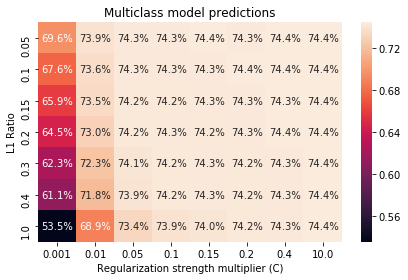

In [10]:
cv_heatmap_file = pathlib.Path("figures", "cross_validation", "single_cell_multiclass_train.png")
cross_validation_performance(cv_pipeline, cv_heatmap_file)

classify__C,0.001,0.010,0.050,0.100,0.150,0.200,0.400,10.000
classify__l1_ratio,,,,,,,,
0.05,0.332450,0.333122,0.336467,0.335990,0.336143,0.336310,0.336473,0.335994
0.10,0.339741,0.333532,0.335385,0.336242,0.336230,0.335842,0.336390,0.335994
0.15,0.332234,0.332532,0.333899,0.335778,0.336254,0.336249,0.336151,0.335993
0.20,0.301757,0.331753,0.334162,0.335287,0.336090,0.336267,0.336010,0.335993
0.30,0.154741,0.331652,0.333110,0.334536,0.335299,0.335921,0.336176,0.336067
0.40,0.159593,0.333196,0.332679,0.334248,0.334752,0.335384,0.336271,0.336148
1.00,0.159593,0.340172,0.330492,0.332935,0.333122,0.334605,0.334907,0.336158


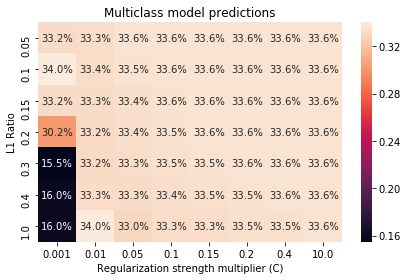

In [11]:
cv_heatmap_file = pathlib.Path("figures", "cross_validation", "single_cell_multiclass_train_shuffled.png")
cross_validation_performance(shuffle_cv_pipeline, cv_heatmap_file)

## Output model coefficients

In [12]:
coef_file = pathlib.Path("coefficients", "single_cell_multiclass_coefficients.tsv")
coef_df = output_coefficients(
    cv_pipeline, data_dict["train"]["x"], y_recode_reverse, coef_file
)

coef_df.head()

,WT parental,Clone A,Clone E
feature,,,
Cells_AreaShape_Center_X,-0.004546,-0.012042,-0.011397
Cells_AreaShape_Center_Y,-0.028817,-0.032763,0.048197
Cells_AreaShape_Compactness,0.142783,-0.062950,-0.035459
Cells_AreaShape_Eccentricity,0.007360,-0.021722,0.018757
Cells_AreaShape_Extent,0.009453,0.016111,-0.012926


In [13]:
shuff_coef_file = pathlib.Path("coefficients", "single_cell_multiclass_coefficients_shuffled.tsv")
shuff_coef_df = output_coefficients(
    shuffle_cv_pipeline, data_dict["train"]["x"], y_recode_reverse, shuff_coef_file
)

shuff_coef_df.head()

,WT parental,Clone A,Clone E
feature,,,
Cells_AreaShape_Center_X,0.000000,0.000000,0.0
Cells_AreaShape_Center_Y,0.000000,0.000000,0.0
Cells_AreaShape_Compactness,0.024897,-0.000139,0.0
Cells_AreaShape_Eccentricity,0.000000,0.000000,0.0
Cells_AreaShape_Extent,0.000000,0.000000,0.0


## Apply models to data and save output scores

In [14]:
scores_dict = {}
for data_fit in data_dict:
    scores_dict[data_fit] = {}
    for shuffled in [True, False]:
        if shuffled:
            trained_pipeline = shuffle_cv_pipeline
        else:
            trained_pipeline = cv_pipeline

        scores_dict[data_fit][f"shuffled_{shuffled}"] = model_apply(
            model=trained_pipeline.best_estimator,
            x_df=data_dict[data_fit]["x"],
            meta_df=data_dict[data_fit]["meta"],
            y_recode=y_recode_reverse,
            data_fit=data_fit,
            shuffled=shuffled
        )

In [15]:
scores_df = []
for data_fit in data_dict:
    for shuffled in [False, True]:
        scores_df.append(scores_dict[data_fit][f"shuffled_{shuffled}"])

scores_df = pd.concat(scores_df, axis="rows").reset_index(drop=True)

output_file = pathlib.Path("scores", "all_single_cell_scores.tsv.gz")
scores_df.to_csv(output_file, sep="\t", compression="gzip", index=False)

print(scores_df.shape)
scores_df.head()

(138218, 16)


,WT parental,Clone A,Clone E,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,Metadata_treatment_time,Metadata_cell_density,data_fit,shuffled
0,0.177995,0.764352,0.057653,224509484233353390719776067605878841752,467,218360,F08,218360,Clone A,218360,20200626-WTpAE-Lo,0.1% DMSO,13 hr,2.5x10^3 cells/well,train,False
1,0.776132,0.091972,0.131896,40616088648198851399731861275720782457,817,218360,E08,218360,WT parental,218360,20200626-WTpAE-Lo,0.1% DMSO,13 hr,2.5x10^3 cells/well,train,False
2,0.000365,0.307521,0.692115,118538072187850477949363265188742377263,471,218360,G02,218360,Clone E,218360,20200626-WTpAE-Lo,0.1% DMSO,13 hr,2.5x10^3 cells/well,train,False
3,0.078366,0.420937,0.500697,85463692195036949208551607101546117020,625,218360,D06,218360,Clone E,218360,20200626-WTpAE-Lo,0.1% DMSO,13 hr,2.5x10^3 cells/well,train,False
4,0.575521,0.054577,0.369902,238788076090986705009540610672334648798,847,218360,B08,218360,WT parental,218360,20200626-WTpAE-Lo,0.1% DMSO,13 hr,2.5x10^3 cells/well,train,False


## Output Models to File

In [16]:
model_file = pathlib.Path("models", "multiclass_cloneAE_wildtype.joblib")
top_model = cv_pipeline.best_estimator_.named_steps["classify"]
dump(top_model, model_file)

shuffle_model_file = pathlib.Path("models", "multiclass_cloneAE_wildtype_shuffled.joblib")
top_shuffle_model = shuffle_cv_pipeline.best_estimator_.named_steps["classify"]
dump(top_shuffle_model, shuffle_model_file)

['models/multiclass_cloneAE_wildtype_shuffled.joblib']

In [17]:
top_model

LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.05, max_iter=50,
                   multi_class='ovr', penalty='elasticnet', random_state=0,
                   solver='saga', tol=0.001)